In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))

In [3]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [5]:

from certainty import EventSentence, load_file, convert_events, EventType, bootstrap_metrics

/home/peder/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()
2025-04-06 15:59:02.687984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-06 15:59:02.723267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-06 15:59:03.399978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
sns.set_theme(rc={'figure.figsize':(11.7,4.27)})

In [7]:
ace_train = load_file("en_train.json")
ace_dev = load_file("en_dev.json")
ace_test = load_file("en_test.json")

In [8]:
dev_data = pd.DataFrame(ace_dev).drop_duplicates('text').drop_duplicates('events')
dev_events = list(convert_events(dev_data.to_dict('records')))

In [9]:
dev_df = pd.DataFrame(dev_events)

In [10]:
asserted_count = len(dev_df[dev_df['modality'] == 'Asserted'])
other_count = len(dev_df[dev_df['modality'] == 'Other'])
total = asserted_count + other_count

In [14]:
dev_df

,sent_id,text,type,modality,label,polarity,genericity,trigger,trigger_idx,arguments
0,bc/CNN_IP_20030329.1600.00-2/001,As they get ready to head over hostile territo...,Transport,Other,0,Positive,Specific,head over,21:30,"[[[hostile territory], [31:48], Destination], ..."
1,bc/CNN_IP_20030329.1600.00-2/002,We know where they 're at so we simply avoid t...,Attack,Other,0,Positive,Generic,defeat,173:179,"[[[they], [14:18], Attacker], [[we], [122:124]..."
2,bc/CNN_IP_20030329.1600.00-2/002,We know where they 're at so we simply avoid t...,Attack,Other,0,Positive,Generic,shot,97:101,"[[[they], [14:18], Attacker], [[us], [117:119]..."
3,bc/CNN_IP_20030329.1600.00-2/003,"Well , as coalition forces push north , they a...",Transfer-Ownership,Asserted,1,Positive,Generic,captured,118:126,"[[[coalition forces], [10:26], Beneficiary], [..."
4,bc/CNN_IP_20030329.1600.00-2/004,"Seemingly deserted , these battered buildings ...",Attack,Other,0,Positive,Generic,threat,60:66,"[[[these battered buildings], [21:45], Place],..."
...,...,...,...,...,...,...,...,...,...,...
491,wl/FLOPPINGACES_20041117.2002.024/006,"On Sunday , Marines found the mutilated body o...",Attack,Asserted,1,Positive,Specific,assault,126:133,"[[[Sunday], [3:9], Time-Within], [[U.S.], [121..."
492,wl/FLOPPINGACES_20041117.2002.024/007,These are the reasons that none of these mothe...,Execute,Other,0,Positive,Specific,shot,124:128,"[[[they], [91:95], Person]]"
493,wl/FLOPPINGACES_20041117.2002.024/008,Torturing this poor women for what,Injure,Asserted,1,Positive,Specific,Torturing,0:9,"[[[this poor women], [10:25], Victim]]"
494,wl/FLOPPINGACES_20041117.2002.024/009,Mrs. Hassan speak s perfect Arabic and she has...,Die,Asserted,1,Positive,Specific,killed,77:83,"[[[she], [65:68], Victim], [[men in pajamas], ..."


In [15]:
train_data = pd.DataFrame(ace_train).drop_duplicates('text').drop_duplicates('events')
train_events = list(convert_events(train_data.to_dict('records')))
train_df = pd.DataFrame(train_events)

In [12]:
gnn_misclassified = pd.read_csv('../results/gnn_misclassified.csv').drop_duplicates("Input Text")

In [13]:
gnn_misclassified.head()

,Input Text,True Label,Predicted Label,Event type
0,As they get ready to head over hostile territo...,Other,Asserted,Transport
1,"They have n't hit anybody , but is n't it risk...",Asserted,Other,Attack
2,Eight hundred of those sorties will be strike ...,Asserted,Other,Attack
3,There were times when the 7th Cavalry itself g...,Asserted,Other,Attack
4,"Earlier in the day , the 1st Brigade of the 3r...",Asserted,Other,Attack


In [18]:
df = pd.read_csv('../results/metrics_baseline_trigger_and_type.csv')
P = 356
N = 140
total = 496
TP = df['eval/recall']*P
FP = TP/(df['eval/precision'])-TP
FN = TP/(df['eval/recall'])-TP
TN = (df['eval/accuracy']*(TP + FP + FN) - TP)/(1-df['eval/accuracy'])
recall_0 = TN/(TN+FP)
precision_0 = TN/(TN+FN)
df['eval/recall_0'] = recall_0
df['eval/precision_0'] = precision_0

df['Macro avg r'] = (df['eval/recall_0']+df['eval/recall'])/2
df['Macro avg p'] = (df['eval/precision_0']+df['eval/precision'])/2
df['Macro avg f1'] = (df['eval/f1_class_0']+df['eval/f1'])/2

df['Weighted avg r'] = ((other_count/total)* df['eval/recall_0']+(asserted_count/total) * df['eval/recall'])
df['Weighted avg p'] = ((other_count/total)* df['eval/precision_0']+(asserted_count/total) *df['eval/precision'])
df['Weighted avg f1'] = ((other_count/total) * df['eval/f1_class_0']+(asserted_count/total) *df['eval/f1'])

stats_df = df[df['trigger']=='trigger'].describe().loc[['mean', 'std']][['eval/f1', 
                                                                         'eval/f1_class_0', 
                                                                         'eval/accuracy', 
                                                                         'eval/recall', 
                                                                         'eval/recall_0', 
                                                                         'eval/precision', 
                                                                         'eval/precision_0', 
                                                                         'Macro avg r', 
                                                                         'Macro avg p', 
                                                                         'Macro avg f1', 
                                                                         'Weighted avg r',
                                                                         'Weighted avg p',
                                                                         'Weighted avg f1',
                                                                         'Runtime']]
stats_df['Runtime'] = pd.to_timedelta(stats_df['Runtime'], unit="s")
stats_df['Runtime'] = stats_df['Runtime'].apply(lambda x: 
    f"{x.components.hours} hours {x.components.minutes} minutes" if x.components.hours > 0 
    else f"{x.components.minutes} minutes"
)
stats_df

,eval/f1,eval/f1_class_0,eval/accuracy,eval/recall,eval/recall_0,eval/precision,eval/precision_0,Macro avg r,Macro avg p,Macro avg f1,Weighted avg r,Weighted avg p,Weighted avg f1,Runtime
mean,0.893106,0.713805,0.844355,0.906180,0.687143,0.880431,0.742805,0.796661,0.811618,0.803455,0.844355,0.841585,0.842497,49 minutes
std,0.009446,0.021519,0.013174,0.013115,0.015485,0.006493,0.030123,0.013572,0.018089,0.015456,0.013174,0.012915,0.012828,1 minutes


In [24]:
stats_df=stats_df.rename(columns={"eval/f1": "f1 Asserted", "eval/f1_class_0": "f1 Other", "eval/accuracy": "Accuracy", "eval/recall": "Recall Asserted", "eval/precision": "Precision Asserted", "eval/precision_0": "Precision Other", "eval/recall_0": "Recall Other"}).T

In [26]:
stats_df['mean_numeric'] = (pd.to_numeric(stats_df['mean'], errors='coerce')*100).round(1)
stats_df['std_numeric'] = (pd.to_numeric(stats_df['std'], errors='coerce')*100).round(1)

stats_df['mean_std'] = stats_df.apply(
    lambda row: f"{row['mean_numeric']:.1f} ± {row['std_numeric']:.1f}" 
    if pd.notna(row['mean_numeric']) and pd.notna(row['std_numeric'])
    else f"{row['mean']} ± {row['std']}",  # Keep original format for Runtime
    axis=1
)


In [27]:
print(stats_df[['mean_std']].T[['Precision Asserted', 'Recall Asserted', 'f1 Asserted']].to_latex())
print(stats_df[['mean_std']].T[['Precision Other', 'Recall Other', 'f1 Other']].to_latex())
print(stats_df[['mean_std']].T[['Macro avg p', 'Macro avg r', 'Macro avg f1']].to_latex())
print(stats_df[['mean_std']].T[['Weighted avg p', 'Weighted avg r', 'Weighted avg f1']].to_latex)

\begin{tabular}{llll}
\toprule
{} & Precision Asserted & Recall Asserted & f1 Asserted \\
\midrule
mean\_std &         88.0 ± 0.6 &      90.6 ± 1.3 &  89.3 ± 0.9 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Precision Other & Recall Other &    f1 Other \\
\midrule
mean\_std &      74.3 ± 3.0 &   68.7 ± 1.5 &  71.4 ± 2.2 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Macro avg p & Macro avg r & Macro avg f1 \\
\midrule
mean\_std &  81.2 ± 1.8 &  79.7 ± 1.4 &   80.3 ± 1.5 \\
\bottomrule
\end{tabular}

<bound method NDFrame.to_latex of          Weighted avg p Weighted avg r Weighted avg f1
mean_std     84.2 ± 1.3     84.4 ± 1.3      84.2 ± 1.3>


/tmp/ipykernel_39480/805861740.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df[['mean_std']].T[['Precision Asserted', 'Recall Asserted', 'f1 Asserted']].to_latex())
/tmp/ipykernel_39480/805861740.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df[['mean_std']].T[['Precision Other', 'Recall Other', 'f1 Other']].to_latex())
/tmp/ipykernel_39480/805861740.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the 

,Name,Created,Runtime,State,model,learning_rate,per_device_train_batch_size,frozen,trigger,eval/f1,eval/accuracy,eval/recall,eval/precision,eval/f1_class_0,eval/f1_class_1,eval/recall_0,eval/precision_0
0,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T09:39:56.000Z,2984,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32,False,type,0.896936,0.850806,0.904494,0.889503,0.729927,0.896936,0.714286,0.746269
1,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T08:40:46.000Z,2986,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32,False,type,0.905089,0.860887,0.924157,0.886792,0.739623,0.905089,0.700000,0.784000
2,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T07:49:00.000Z,2984,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32,False,type,0.895978,0.848790,0.907303,0.884932,0.723247,0.895978,0.700000,0.748092
3,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-28T16:24:20.000Z,3157,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32,False,type,0.899587,0.852823,0.918539,0.881402,0.724528,0.899587,0.685714,0.768000
4,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-28T15:27:00.000Z,3160,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32,False,type,0.901685,0.858871,0.901685,0.901685,0.750000,0.901685,0.750000,0.750000


In [18]:

def plot_misclassification_chart(misclassified, dev_df):
    other_value_counts = misclassified[misclassified["True Label"]=="Other"]['Event type'].value_counts()
    asserted_value_counts = misclassified[misclassified["True Label"]=="Asserted"]['Event type'].value_counts()
    df = pd.DataFrame()
    #mis_series = (misclassified_type['Event type'].value_counts() / dev_df['type'].value_counts()).fillna(0)
    df["asserted_misclassified"] = (asserted_value_counts / dev_df[dev_df["modality"] == "Asserted"]['type'].value_counts()).fillna(0)
    df["other_misclassified"] = -(other_value_counts / dev_df[dev_df["modality"] == "Other"]['type'].value_counts()).fillna(0)
    #df["type"] = list(mis_series.index.to_series())
    # df["percent_misclassified"] =  list(mis_series)
    df["other_misclassified"] = df["other_misclassified"].fillna(0)
    # df = df.sort_values(by=["other_misclassified", "asserted_misclassified"], ascending=True)
    df = df.sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    
    sns.barplot(y=df.index, x=df["asserted_misclassified"], color=sns.color_palette("pastel")[0], label="Asserted Misclassified", ax=ax)
    sns.barplot(y=df.index, x=df["other_misclassified"], color=sns.color_palette("pastel")[1], label="Other Misclassified", ax=ax)
    # Add labels and title
    ax.set_xlabel("Misclassification Ratio relative to whole validation set")
    ax.set_ylabel("Event Type")
    ax.set_title("Misclassification Rates by Event Type and modality")
    ax.set_xticks([-1.0, -0.5, -0.25, 0, 0.25, 0.5, 1.0])  # Adjust based on range
    ax.set_xticklabels(["1.0", "0.5", "0.25", "0", "0.25", "0.5", "1.0"])
    ax.legend()
    return fig

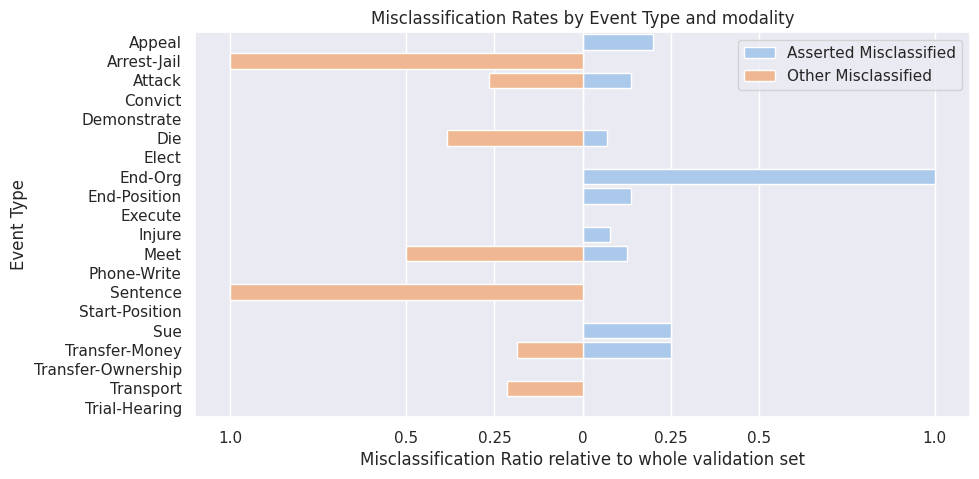

In [19]:
fig = plot_misclassification_chart(gnn_misclassified, dev_df)
fig.savefig('../results/gnn_misclas_rate.png')

In [20]:
gnn_misclassified['Event type'].value_counts()

Attack                30
Transfer-Money        10
Die                    8
Meet                   6
Transport              3
End-Position           3
Arrest-Jail            2
Sue                    2
End-Org                1
Declare-Bankruptcy     1
Appeal                 1
Sentence               1
Injure                 1
Charge-Indict          1
Name: Event type, dtype: int64

<AxesSubplot: xlabel='Predicted Label', ylabel='Count'>

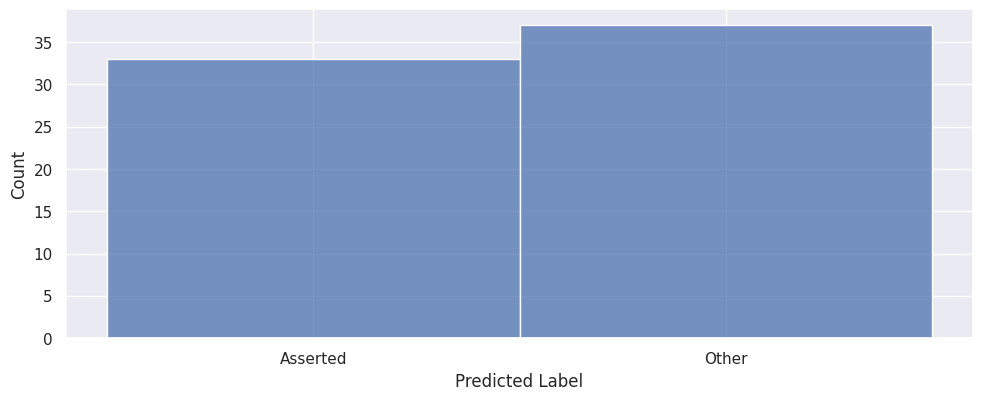

In [21]:
sns.histplot(gnn_misclassified['Predicted Label'])

<AxesSubplot: xlabel='Event type', ylabel='Count'>

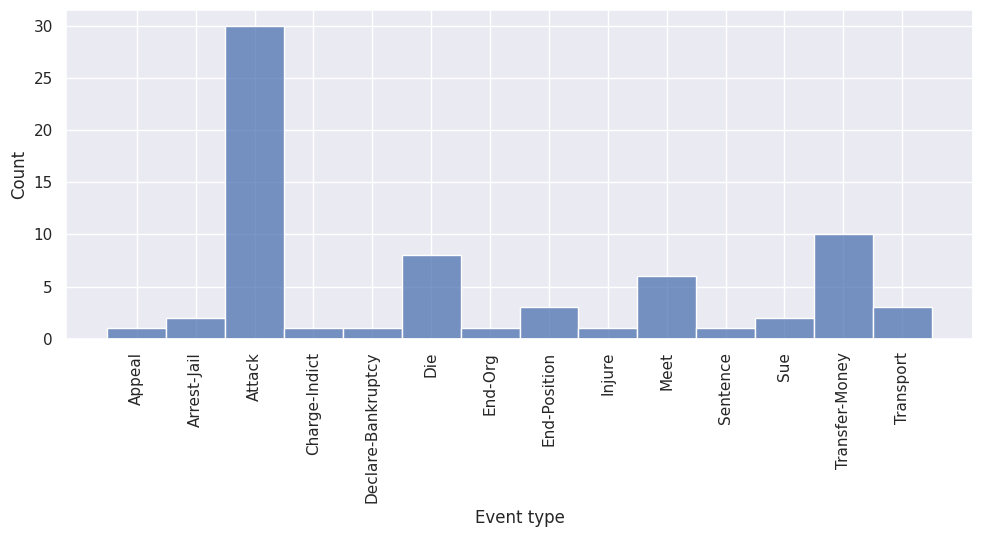

In [22]:
plt.xticks(rotation=90)
sns.histplot(gnn_misclassified['Event type'].sort_values())

In [23]:
ratio = gnn_misclassified['Input Text'].count() / dev_df['text'].count()

<AxesSubplot: >

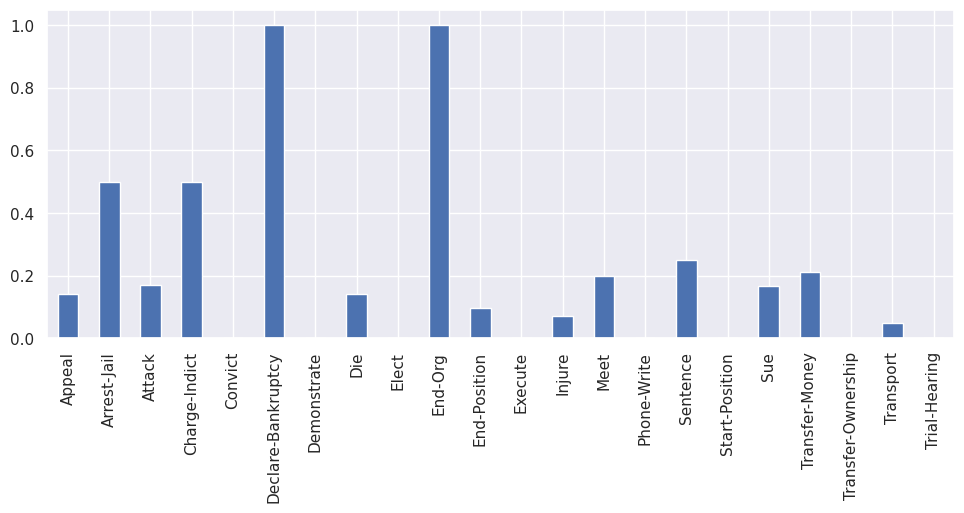

In [24]:
(gnn_misclassified['Event type'].value_counts() / dev_df['type'].value_counts()).fillna(0).plot.bar()

In [110]:

def plot_misclassification_chart_absolute(misclassified, dev_df):
    # Get all unique event types
    all_event_types = dev_df['type'].unique()

    # Get raw misclassified counts
    other_value_counts = misclassified[misclassified["True Label"] == "Other"]['Event type'].value_counts()
    asserted_value_counts = misclassified[misclassified["True Label"] == "Asserted"]['Event type'].value_counts()
    
    # Create DataFrame with all event types, ensuring missing ones are filled with 0
    df = pd.DataFrame(index=all_event_types)
    df["asserted_misclassified"] = asserted_value_counts.reindex(all_event_types, fill_value=0)  # Positive (right side)
    df["other_misclassified"] = -other_value_counts.reindex(all_event_types, fill_value=0)  # Negative (left side)

    # Sort by "asserted_misclassified" (descending) then "other_misclassified" (ascending)
    df = df.sort_index()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.barplot(y=df.index, x=df["asserted_misclassified"], color=sns.color_palette("pastel")[0], label="Asserted Misclassified", ax=ax)
    sns.barplot(y=df.index, x=df["other_misclassified"], color=sns.color_palette("pastel")[1], label="Other Misclassified", ax=ax)
    
    # Labels and title
    ax.set_xlabel("Absolute Misclassification Count")
    ax.set_ylabel("Event Type")
    ax.set_title("Absolute Misclassification Counts by Event Type and Modality")
    
    # Set fixed x-axis limits (0 to 17)
    ax.set_xlim(-19, 19)
    ax.set_xticks(range(-17, 18, 2))  # Tick marks every 2 units
    ax.set_xticklabels([str(abs(x)) for x in ax.get_xticks()])  # Show absolute values
    
    ax.legend()
    
    return fig
    
   

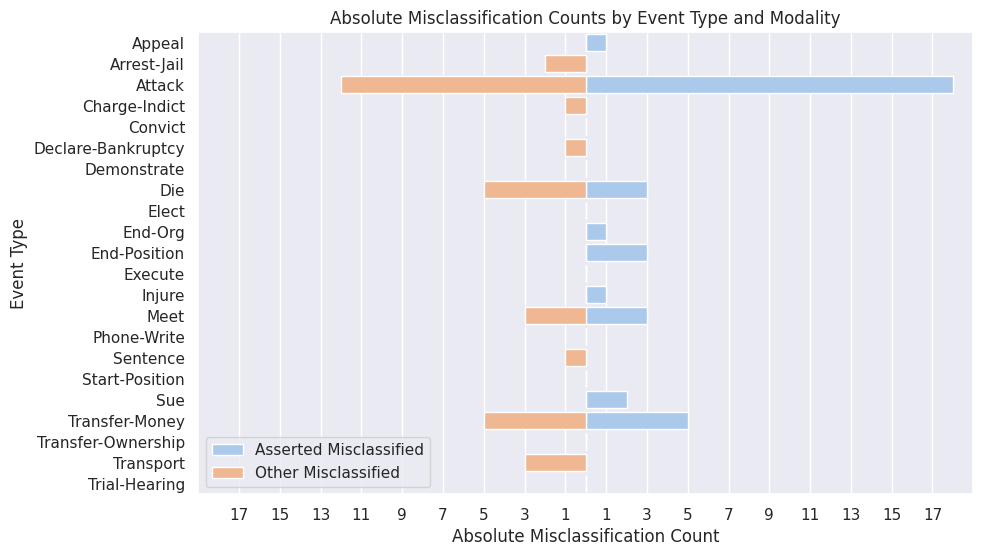

In [111]:
fig = plot_misclassification_chart_absolute(gnn_misclassified, dev_df)
fig.savefig('../results/gnn_absolute_misclassified.png')

In [27]:
mj_baseline = pd.read_csv('../results/majority_baseline.csv', index_col=0)

In [28]:
mj_baseline

,Majority class
Precision Asserted,0.717742
Precision Other,0.000000
Recall Asserted,1.000000
Recall Other,0.000000
f1 Asserted,0.835681
f1 Other,0.000000
Accuracy,0.717742


In [84]:
gnn_df = pd.read_csv('../results/metrics_gnn.csv')

In [85]:
gnn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 5 non-null      object 
 1   Created              5 non-null      object 
 2   Runtime              5 non-null      int64  
 3   State                5 non-null      object 
 4   model                0 non-null      float64
 5   epochs               5 non-null      int64  
 6   eval/accuracy        5 non-null      float64
 7   eval/recall          5 non-null      float64
 8   eval/precision       5 non-null      float64
 9   eval/f1_class_0      5 non-null      float64
 10  eval/f1_class_1      5 non-null      float64
 11  train/learning_rate  5 non-null      float64
 12  eval/precision_0     5 non-null      float64
 13  eval/recall_0        5 non-null      float64
dtypes: float64(9), int64(2), object(3)
memory usage: 688.0+ bytes


In [88]:
gnn_df['trigger'] = ["gnn" for i in range(5)]

In [89]:
gnn_df

,Name,Created,Runtime,State,model,epochs,eval/accuracy,eval/recall,eval/precision,eval/f1_class_0,eval/f1_class_1,train/learning_rate,eval/precision_0,eval/recall_0,trigger
0,GNN_attention_with_lr;random=12392131;model=/f...,2025-03-17T08:31:34.000Z,1294,finished,NaN,100,0.856855,0.910112,0.892562,0.739927,0.901252,0.000004,0.759398,0.721429,gnn
1,GNN_attention_with_lr;random=4783912;model=/fp...,2025-03-17T08:31:32.000Z,1402,finished,NaN,100,0.844758,0.882022,0.899713,0.731707,0.890780,0.000004,0.714286,0.750000,gnn
2,GNN_attention_with_lr;random=1282;model=/fp/pr...,2025-03-17T08:20:08.000Z,1350,finished,NaN,100,0.848790,0.893258,0.895775,0.733096,0.894515,0.000004,0.730496,0.735714,gnn
3,GNN_attention_with_lr;random=42;model=/fp/proj...,2025-03-17T08:20:07.000Z,1337,finished,NaN,100,0.842742,0.901685,0.881868,0.713235,0.891667,0.000004,0.734848,0.692857,gnn
4,GNN_attention_with_lr;random=42;model=/fp/proj...,2025-03-14T15:39:55.000Z,1042,finished,NaN,100,0.838710,0.893258,0.883333,0.710145,0.888268,0.000010,0.720588,0.700000,gnn


In [90]:
stats_df = gnn_df.describe().loc[['mean', 'std']][['eval/f1_class_1', 'eval/f1_class_0', 'eval/accuracy', 'eval/recall', 'eval/recall_0', 'eval/precision', 'eval/precision_0', 'Runtime']]

In [91]:
stats_df['Runtime'] = pd.to_timedelta(stats_df['Runtime'], unit="s")
stats_df['Runtime'] = stats_df['Runtime'].apply(lambda x: 
    f"{x.components.hours} hours {x.components.minutes} minutes" if x.components.hours > 0 
    else f"{x.components.minutes} minutes"
)
stats_df

,eval/f1_class_1,eval/f1_class_0,eval/accuracy,eval/recall,eval/recall_0,eval/precision,eval/precision_0,Runtime
mean,0.893296,0.725622,0.846371,0.896067,0.720000,0.89065,0.731923,21 minutes
std,0.004976,0.013139,0.006896,0.010510,0.023905,0.00779,0.017357,2 minutes


In [92]:
stats_df=stats_df.rename(columns={"eval/f1_class_1": "f1 Asserted", "eval/f1_class_0": "f1 Other", "eval/accuracy": "Accuracy", "eval/recall": "Recall Asserted", "eval/precision": "Precision Asserted", "eval/precision_0": "Precision Other", "eval/recall_0": "Recall Other"}).T

In [93]:
stats_df

,mean,std
f1 Asserted,0.893296,0.004976
f1 Other,0.725622,0.013139
Accuracy,0.846371,0.006896
Recall Asserted,0.896067,0.01051
Recall Other,0.72,0.023905
Precision Asserted,0.89065,0.00779
Precision Other,0.731923,0.017357
Runtime,21 minutes,2 minutes


In [94]:
stats_df['mean_numeric'] = pd.to_numeric(stats_df['mean'], errors='coerce')
stats_df['std_numeric'] = pd.to_numeric(stats_df['std'], errors='coerce')

stats_df['mean_std'] = stats_df.apply(
    lambda row: f"{row['mean_numeric']:.3f} ± {row['std_numeric']:.3f}" 
    if pd.notna(row['mean_numeric']) and pd.notna(row['std_numeric'])
    else f"{row['mean']} ± {row['std']}",  # Keep original format for Runtime
    axis=1
)



In [95]:
metrics = stats_df[['mean_std']]

In [96]:
metrics

,mean_std
f1 Asserted,0.893 ± 0.005
f1 Other,0.726 ± 0.013
Accuracy,0.846 ± 0.007
Recall Asserted,0.896 ± 0.011
Recall Other,0.720 ± 0.024
Precision Asserted,0.891 ± 0.008
Precision Other,0.732 ± 0.017
Runtime,21 minutes ± 2 minutes


In [97]:
metrics['Majority class'] = mj_baseline

/tmp/ipykernel_12270/2437034982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['Majority class'] = mj_baseline


In [98]:
metrics

,mean_std,Majority class
f1 Asserted,0.893 ± 0.005,0.835681
f1 Other,0.726 ± 0.013,0.000000
Accuracy,0.846 ± 0.007,0.717742
Recall Asserted,0.896 ± 0.011,1.000000
Recall Other,0.720 ± 0.024,0.000000
Precision Asserted,0.891 ± 0.008,0.717742
Precision Other,0.732 ± 0.017,0.000000
Runtime,21 minutes ± 2 minutes,NaN


In [99]:
print(metrics[['mean_std', 'Majority class']].to_latex(bold_rows=True))

\begin{tabular}{llr}
\toprule
{} &                mean\_std &  Majority class \\
\midrule
\textbf{f1 Asserted       } &           0.893 ± 0.005 &        0.835681 \\
\textbf{f1 Other          } &           0.726 ± 0.013 &        0.000000 \\
\textbf{Accuracy          } &           0.846 ± 0.007 &        0.717742 \\
\textbf{Recall Asserted   } &           0.896 ± 0.011 &        1.000000 \\
\textbf{Recall Other      } &           0.720 ± 0.024 &        0.000000 \\
\textbf{Precision Asserted} &           0.891 ± 0.008 &        0.717742 \\
\textbf{Precision Other   } &           0.732 ± 0.017 &        0.000000 \\
\textbf{Runtime           } &  21 minutes ± 2 minutes &             NaN \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12270/3022338483.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics[['mean_std', 'Majority class']].to_latex(bold_rows=True))


In [101]:
df = pd.concat([df[df['trigger']=='type'], gnn_df])

In [102]:
df

,Name,Created,Runtime,State,model,learning_rate,per_device_train_batch_size,frozen,trigger,eval/f1,eval/accuracy,eval/recall,eval/precision,eval/f1_class_0,eval/f1_class_1,eval/recall_0,eval/precision_0,epochs,train/learning_rate
0,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T09:39:56.000Z,2984,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32.0,False,type,0.896936,0.850806,0.904494,0.889503,0.729927,0.896936,0.714286,0.746269,NaN,NaN
1,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T08:40:46.000Z,2986,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32.0,False,type,0.905089,0.860887,0.924157,0.886792,0.739623,0.905089,0.700000,0.784000,NaN,NaN
2,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-29T07:49:00.000Z,2984,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32.0,False,type,0.895978,0.848790,0.907303,0.884932,0.723247,0.895978,0.700000,0.748092,NaN,NaN
3,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-28T16:24:20.000Z,3157,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32.0,False,type,0.899587,0.852823,0.918539,0.881402,0.724528,0.899587,0.685714,0.768000,NaN,NaN
4,bert_baseline:/fp/projects01/ec30/models/xlm-r...,2025-01-28T15:27:00.000Z,3160,finished,/fp/projects01/ec30/models/xlm-roberta-large/,0.000005,32.0,False,type,0.901685,0.858871,0.901685,0.901685,0.750000,0.901685,0.750000,0.750000,NaN,NaN
0,GNN_attention_with_lr;random=12392131;model=/f...,2025-03-17T08:31:34.000Z,1294,finished,NaN,NaN,NaN,NaN,gnn,NaN,0.856855,0.910112,0.892562,0.739927,0.901252,0.721429,0.759398,100.0,0.000004
1,GNN_attention_with_lr;random=4783912;model=/fp...,2025-03-17T08:31:32.000Z,1402,finished,NaN,NaN,NaN,NaN,gnn,NaN,0.844758,0.882022,0.899713,0.731707,0.890780,0.750000,0.714286,100.0,0.000004
2,GNN_attention_with_lr;random=1282;model=/fp/pr...,2025-03-17T08:20:08.000Z,1350,finished,NaN,NaN,NaN,NaN,gnn,NaN,0.848790,0.893258,0.895775,0.733096,0.894515,0.735714,0.730496,100.0,0.000004
3,GNN_attention_with_lr;random=42;model=/fp/proj...,2025-03-17T08:20:07.000Z,1337,finished,NaN,NaN,NaN,NaN,gnn,NaN,0.842742,0.901685,0.881868,0.713235,0.891667,0.692857,0.734848,100.0,0.000004
4,GNN_attention_with_lr;random=42;model=/fp/proj...,2025-03-14T15:39:55.000Z,1042,finished,NaN,NaN,NaN,NaN,gnn,NaN,0.838710,0.893258,0.883333,0.710145,0.888268,0.700000,0.720588,100.0,0.000010


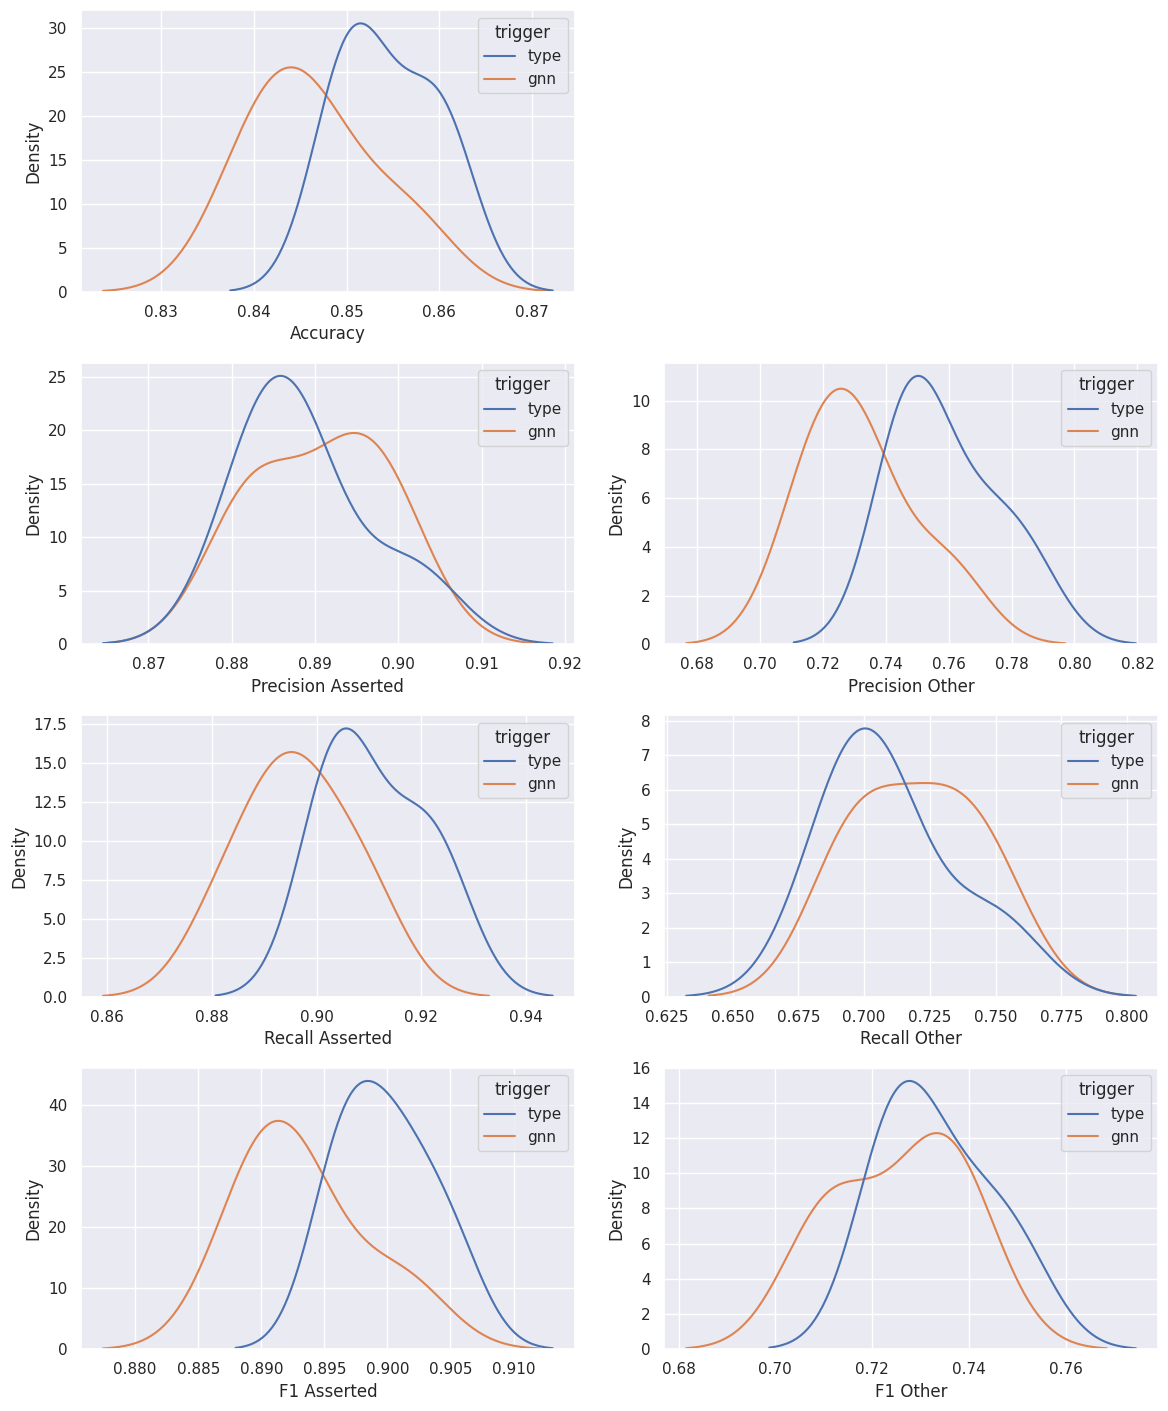

In [103]:
sns.set_theme(rc={'figure.figsize':(11.7, 14.27)})

f, axes = plt.subplots(4, 2)
sns.kdeplot(data=df, x="eval/accuracy", hue="trigger", ax=axes[0][0])
axes[0][1].remove()  # Remove the empty second subplot in the first row
sns.kdeplot(data=df, x="eval/precision", hue="trigger", ax=axes[1][0])
sns.kdeplot(data=df, x="eval/precision_0", hue="trigger", ax=axes[1][1])
sns.kdeplot(data=df, x="eval/recall", hue="trigger", ax=axes[2][0])
sns.kdeplot(data=df, x="eval/recall_0", hue="trigger", ax=axes[2][1])
sns.kdeplot(data=df, x="eval/f1_class_1", hue="trigger", ax=axes[3][0])
sns.kdeplot(data=df, x="eval/f1_class_0", hue="trigger", ax=axes[3][1])

# Rename x-axis for the last two plots
axes[0][0].set_xlabel("Accuracy")
axes[1][0].set_xlabel("Precision Asserted")
axes[1][1].set_xlabel("Precision Other")
axes[2][0].set_xlabel("Recall Asserted")
axes[2][1].set_xlabel("Recall Other")
axes[3][0].set_xlabel("F1 Asserted")
axes[3][1].set_xlabel("F1 Other")

# Adjust layout to prevent overlap
plt.tight_layout()

f.savefig("../results/gnn_metrics.png", dpi=300)  # Save with high resolution

In [127]:
from sklearn.metrics import confusion_matrix


In [69]:
conf_data = pd.read_csv("../results/gnn_cm_data.csv")

In [70]:
conf_data

,Actual,Predicted,_defaultColorIndex,id,nPredictions,name
0,Other,Other,13,chhq9u4c,105,GNN_attention_with_lr;random=4783912;model=/fp...
1,Other,Asserted,13,chhq9u4c,35,GNN_attention_with_lr;random=4783912;model=/fp...
2,Asserted,Other,13,chhq9u4c,42,GNN_attention_with_lr;random=4783912;model=/fp...
3,Asserted,Asserted,13,chhq9u4c,314,GNN_attention_with_lr;random=4783912;model=/fp...


In [72]:
import numpy as np

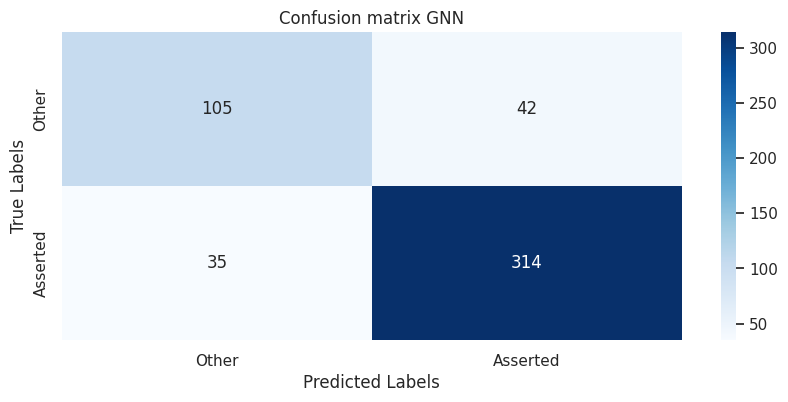

In [76]:

sns.set_theme(rc={'figure.figsize':(10, 4)})

conf_matrix_gnn = np.array([[conf_data.iloc[0]['nPredictions'],  conf_data.iloc[2]['nPredictions']],
                      [ conf_data.iloc[1]['nPredictions'], conf_data.iloc[3]['nPredictions']]])

class_labels = ["Other", "Asserted"]


f, axes = plt.subplots(1, 1)

sns.heatmap(conf_matrix_gnn, fmt="", annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes)

# Labels and title
axes.set_title("Confusion matrix GNN")
axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")

f.savefig("../results/confusion_gnn.png", dpi=300)
